In [ ]:
# --- Mount Google Drive (if needed) ---
from google.colab import drive
drive.mount('/content/drive')

# --- Install Libraries ---
!pip install pandas scikit-learn matplotlib tqdm --quiet

# --- 1. Load Libraries ---
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# --- 2. Load Your Files ---
healthy_data_path = '/content/drive/MyDrive/ahmad dataset4.5.25/turbine_T01_data.csv'
real_fault_data_path = '/content/drive/MyDrive/ahmad dataset4.5.25/failure_only_sensor_data_with_failure_info (1).csv'

healthy_data = pd.read_csv(healthy_data_path)
real_fault_data = pd.read_csv(real_fault_data_path)

# Force healthy data to float
healthy_data = healthy_data.apply(lambda col: col.astype(float) if np.issubdtype(col.dtype, np.number) else col)

# --- 3. Prepare Real Fault Patterns ---
cols_to_ignore = ['Component'] if 'Component' in real_fault_data.columns else []
real_fault_data = real_fault_data.drop(columns=[col for col in cols_to_ignore if col in real_fault_data.columns], errors='ignore')

common_columns = list(set(healthy_data.columns).intersection(set(real_fault_data.columns)))
healthy_data = healthy_data[common_columns]
real_fault_data = real_fault_data[common_columns + ['Remarks']]

remark_patterns = {}
remarks_list = real_fault_data['Remarks'].unique().tolist()

for remark in remarks_list:
    subset = real_fault_data[real_fault_data['Remarks'] == remark].drop(columns=['Remarks'])
    if not subset.empty:
        subset_numeric = subset.select_dtypes(include=[np.number])
        mean_faulty = subset_numeric.mean()
        mean_normal = healthy_data.select_dtypes(include=[np.number]).mean()
        diff_percent = 100 * (mean_faulty - mean_normal) / mean_normal
        significant_sensors = diff_percent[abs(diff_percent) >= 10].index.tolist()
        pattern = {sensor: diff_percent[sensor] for sensor in significant_sensors}
        remark_patterns[remark] = pattern

# --- 4. Define Advanced Fault Injection ---
def inject_faults_advanced(healthy_df, remarks_list, remark_patterns, noise_std_dev=0.01, overlap_chance=0.1, progressive_chance=0.1, missing_sensor_chance=0):
    synthetic_df = healthy_df.copy()
    n_total = len(synthetic_df)
    n_faults = random.randint(int(0.20 * n_total), int(0.25 * n_total))
    fault_rows = random.sample(range(n_total), n_faults)
    fault_remarks_per_row = random.choices(remarks_list, k=n_faults)

    synthetic_df['Fault_Flag'] = 0
    synthetic_df['Remarks'] = None

    for idx, remark in zip(fault_rows, fault_remarks_per_row):
        apply_overlap = random.random() < overlap_chance
        apply_progressive = random.random() < progressive_chance

        if apply_overlap:
            other_remark = random.choice(remarks_list)
            pattern1 = remark_patterns.get(remark, {})
            pattern2 = remark_patterns.get(other_remark, {})
            all_keys = set(pattern1.keys()).union(pattern2.keys())
            mixed_pattern = {k: 0.5 * pattern1.get(k, 0) + 0.5 * pattern2.get(k, 0) for k in all_keys}
            fault_pattern = mixed_pattern
            label = f"{remark} + {other_remark}"
        else:
            fault_pattern = remark_patterns.get(remark, {})
            label = remark

        for sensor, shift_percent in fault_pattern.items():
            if sensor in synthetic_df.columns:
                progressive_factor = random.uniform(0.5, 1.5) if apply_progressive else 1.0
                synthetic_df.at[idx, sensor] *= (1 + (shift_percent/100.0) * progressive_factor)
                noise = np.random.normal(0, noise_std_dev)
                synthetic_df.at[idx, sensor] *= (1 + noise)

        if random.random() < missing_sensor_chance:
            missing_sensors = random.sample(list(synthetic_df.columns), k=random.randint(1, 5))
            for sensor in missing_sensors:
                if sensor in synthetic_df.columns and np.issubdtype(synthetic_df[sensor].dtype, np.number):
                    synthetic_df.at[idx, sensor] = np.nan

        synthetic_df.at[idx, 'Fault_Flag'] = 1
        synthetic_df.at[idx, 'Remarks'] = label

    return synthetic_df

# --- 5. Generate Synthetic Data ---
healthy_train, healthy_test = train_test_split(healthy_data, test_size=0.2, random_state=42)
healthy_train = healthy_train.reset_index(drop=True)
healthy_test = healthy_test.reset_index(drop=True)

print("Injecting faults into TRAIN set...")
synthetic_train = inject_faults_advanced(healthy_train, remarks_list, remark_patterns)
print("Injecting faults into TEST set...")
synthetic_test = inject_faults_advanced(healthy_test, remarks_list, remark_patterns)

synthetic_train['Remarks'] = synthetic_train['Remarks'].fillna('Normal')
synthetic_test['Remarks'] = synthetic_test['Remarks'].fillna('Normal')

# --- 6. Save the Synthetic Data ---
output_train_path = '/content/drive/MyDrive/ahmad dataset4.5.25/synthetic_train.csv'
output_test_path = '/content/drive/MyDrive/ahmad dataset4.5.25/synthetic_test.csv'

synthetic_train.to_csv(output_train_path, index=False)
synthetic_test.to_csv(output_test_path, index=False)

print(f"✅ Synthetic training set saved to: {output_train_path}")
print(f"✅ Synthetic testing set saved to: {output_test_path}")

# --- 7. Preprocessing After Injection (Handle NaNs) ---

# Load freshly saved synthetic data
synthetic_train = pd.read_csv(output_train_path)
synthetic_test = pd.read_csv(output_test_path)

# Patch missing Remarks again
synthetic_train['Remarks'] = synthetic_train['Remarks'].fillna('Normal')
synthetic_test['Remarks'] = synthetic_test['Remarks'].fillna('Normal')

# Prepare Features and Labels
def prepare_data(df):
    X = df.drop(columns=['Fault_Flag', 'Remarks'], errors='ignore')
    X = X.select_dtypes(include=[np.number])
    y = df['Remarks']
    return X, y

X_train_raw, y_train = prepare_data(synthetic_train)
X_test_raw, y_test = prepare_data(synthetic_test)

# Impute Missing Values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_raw)
X_test_imputed = imputer.transform(X_test_raw)

# Encode Labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Plot distribution of classes
labels = le.inverse_transform(np.unique(y_train_encoded))
counts = pd.Series(y_train_encoded).value_counts().sort_index()



Mounted at /content/drive
Injecting faults into TRAIN set...
Injecting faults into TEST set...
✅ Synthetic training set saved to: /content/drive/MyDrive/ahmad dataset4.5.25/synthetic_train.csv
✅ Synthetic testing set saved to: /content/drive/MyDrive/ahmad dataset4.5.25/synthetic_test.csv


In [ ]:
# --- Fill missing Remarks with 'Normal' ---
synthetic_train['Remarks'] = synthetic_train['Remarks'].fillna('Normal')
synthetic_test['Remarks'] = synthetic_test['Remarks'].fillna('Normal')

# --- 7. Prepare Features and Labels ---
def prepare_data(df):
    X = df.drop(columns=['Fault_Flag', 'Remarks'])   # Drop helper columns
    X = X.select_dtypes(include=[np.number])         # Keep only numeric columns (drop timestamps, etc.)
    y = df['Remarks']                                # Label = Remarks
    return X, y

X_train, y_train = prepare_data(synthetic_train)
X_test, y_test = prepare_data(synthetic_test)

# --- 8. Label Encoding and Scaling ---
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Label encode the fault labels (Remarks)
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Scale features (important for most ML models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)




In [ ]:
alpha  = 0.6    # controls (1 - Fault-Only Accuracy)
epsilon = 0.4   # controls Model Size
gamma = 0     # controls Training Time
delta = 0     # controls Inference Time
beta   = 0      # controls Model Complexity (currently disabled)


In [ ]:
# --- Grid Search for Best Tradeoff Between Size, Speed, and Fault-Only Accuracy ---

import time
import pickle
import sys
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Settings to try
n_estimators_list = [5, 10, 20, 50, 100]
max_depth_list = [3, 5, 7, 10]

max_possible_complexity = max(n_estimators_list) * max(max_depth_list)

results = []

for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        print(f"\nTraining RandomForest with n_estimators={n_estimators}, max_depth={max_depth}...")

        rf_model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=42
        )

        # Measure training time
        start_train = time.time()
        rf_model.fit(X_train_scaled, y_train_encoded)
        train_time = time.time() - start_train

        # Measure inference time
        start_infer = time.time()
        y_pred = rf_model.predict(X_test_scaled)
        inference_time = time.time() - start_infer

        # Fault-Only Accuracy
        normal_label_index = np.where(le.classes_ == 'Normal')[0][0]
        fault_mask = (y_test_encoded != normal_label_index)
        y_test_faults = y_test_encoded[fault_mask]
        y_pred_faults = y_pred[fault_mask]
        fault_accuracy = accuracy_score(y_test_faults, y_pred_faults)

        # ✅ Overall Accuracy
        overall_accuracy = accuracy_score(y_test_encoded, y_pred)

        # Model Complexity (normalized)
        model_complexity = (n_estimators * max_depth) / max_possible_complexity

        # Model Size
        model_size_bytes = sys.getsizeof(pickle.dumps(rf_model))
        model_size_MB = model_size_bytes / (1024 * 1024)  # MB

        results.append({
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'fault_accuracy': fault_accuracy,
            'overall_accuracy': overall_accuracy,
            'model_complexity': model_complexity,
            'train_time_sec': train_time,
            'inference_time_sec': inference_time,
            'model_size_MB': model_size_MB
        })

# --- After Grid Search: Normalize and Calculate Cost ---




Training RandomForest with n_estimators=5, max_depth=3...

Training RandomForest with n_estimators=5, max_depth=5...

Training RandomForest with n_estimators=5, max_depth=7...

Training RandomForest with n_estimators=5, max_depth=10...

Training RandomForest with n_estimators=10, max_depth=3...

Training RandomForest with n_estimators=10, max_depth=5...

Training RandomForest with n_estimators=10, max_depth=7...

Training RandomForest with n_estimators=10, max_depth=10...

Training RandomForest with n_estimators=20, max_depth=3...

Training RandomForest with n_estimators=20, max_depth=5...

Training RandomForest with n_estimators=20, max_depth=7...

Training RandomForest with n_estimators=20, max_depth=10...

Training RandomForest with n_estimators=50, max_depth=3...

Training RandomForest with n_estimators=50, max_depth=5...

Training RandomForest with n_estimators=50, max_depth=7...

Training RandomForest with n_estimators=50, max_depth=10...

Training RandomForest with n_estimators

In [ ]:
# Convert to DataFrame
results_df = pd.DataFrame(results)

# Normalize fields
results_df['normalized_train_time'] = results_df['train_time_sec'] / results_df['train_time_sec'].max()
results_df['normalized_inference_time'] = results_df['inference_time_sec'] / results_df['inference_time_sec'].max()
results_df['normalized_model_size'] = results_df['model_size_MB'] / results_df['model_size_MB'].max()

# Calculate total cost (only using fault_accuracy)
results_df['cost'] = (
    alpha * (1 - results_df['fault_accuracy']) +
    beta * results_df['model_complexity'] +
    gamma * results_df['normalized_train_time'] +
    delta * results_df['normalized_inference_time'] +
    epsilon * results_df['normalized_model_size']
)

# --- Find Best Model ---
best_row = results_df.loc[results_df['cost'].idxmin()]

print("\n🎯 Full Grid Search Results (sorted by COST):")
print(results_df.sort_values(by='cost'))

print("\n🚀 Best Parameters Found:")
print(f"n_estimators = {int(best_row['n_estimators'])}")
print(f"max_depth = {int(best_row['max_depth'])}")
print(f"Fault-Only Accuracy = {best_row['fault_accuracy']*100:.2f}%")
print(f"Overall Accuracy = {best_row['overall_accuracy']*100:.2f}%")
print(f"Training Time (s) = {best_row['train_time_sec']:.4f}")
print(f"Inference Time (s) = {best_row['inference_time_sec']:.6f}")
print(f"Model Size (MB) = {best_row['model_size_MB']:.4f}")
print(f"Final Cost = {best_row['cost']:.6f}")



🎯 Full Grid Search Results (sorted by COST):
    n_estimators  max_depth  fault_accuracy  overall_accuracy  \
3              5         10        0.868315          0.970483   
7             10         10        0.883443          0.973874   
10            20          7        0.846367          0.965468   
6             10          7        0.822502          0.959975   
2              5          7        0.779459          0.950518   
14            50          7        0.848498          0.966041   
11            20         10        0.890901          0.975546   
18           100          7        0.860857          0.968811   
13            50          5        0.720009          0.936954   
17           100          5        0.724270          0.938196   
9             20          5        0.679310          0.928022   
5             10          5        0.636906          0.918565   
1              5          5        0.608140          0.912117   
15            50         10        0.895589 

In [ ]:
# --- MLP Grid Search with Full Cost Evaluation ---

from sklearn.neural_network import MLPClassifier

# MLP parameters to try
hidden_layer_sizes_list = [(64,), (64, 32), (128, 64, 32), (128, 64, 32, 16)]
learning_rate_init_list = [0.01]

results_mlp = []

max_possible_complexity_mlp = max([np.prod(layers) for layers in hidden_layer_sizes_list])

for hidden_layers in hidden_layer_sizes_list:
    for learning_rate in learning_rate_init_list:
        print(f"\nTraining MLP with hidden_layers={hidden_layers}, learning_rate_init={learning_rate}...")

        mlp_model = MLPClassifier(
            hidden_layer_sizes=hidden_layers,
            activation='relu',
            learning_rate_init=learning_rate,
            max_iter=100,
            random_state=42
        )

        # Measure training time
        start_train = time.time()
        mlp_model.fit(X_train_scaled, y_train_encoded)
        train_time = time.time() - start_train

        # Measure inference time
        start_infer = time.time()
        y_pred = mlp_model.predict(X_test_scaled)
        inference_time = time.time() - start_infer

        # Fault-Only Accuracy
        normal_label_index = np.where(le.classes_ == 'Normal')[0][0]
        fault_mask = (y_test_encoded != normal_label_index)
        y_test_faults = y_test_encoded[fault_mask]
        y_pred_faults = y_pred[fault_mask]
        fault_accuracy = accuracy_score(y_test_faults, y_pred_faults)

        # ✅ Overall Accuracy
        overall_accuracy = accuracy_score(y_test_encoded, y_pred)

        # Model Complexity for MLP
        model_complexity = np.prod(hidden_layers) / max_possible_complexity_mlp

        # Model Size
        model_size_bytes = sys.getsizeof(pickle.dumps(mlp_model))
        model_size_MB = model_size_bytes / (1024 * 1024)

        results_mlp.append({
            'hidden_layers': hidden_layers,
            'learning_rate_init': learning_rate,
            'fault_accuracy': fault_accuracy,
            'overall_accuracy': overall_accuracy,
            'model_complexity': model_complexity,
            'train_time_sec': train_time,
            'inference_time_sec': inference_time,
            'model_size_MB': model_size_MB
        })





Training MLP with hidden_layers=(64,), learning_rate_init=0.01...

Training MLP with hidden_layers=(64, 32), learning_rate_init=0.01...

Training MLP with hidden_layers=(128, 64, 32), learning_rate_init=0.01...

Training MLP with hidden_layers=(128, 64, 32, 16), learning_rate_init=0.01...


In [ ]:
# --- After Grid Search: Normalize and Calculate Cost ---

# Convert to DataFrame
results_mlp_df = pd.DataFrame(results_mlp)

# Normalize fields
results_mlp_df['normalized_train_time'] = results_mlp_df['train_time_sec'] / results_mlp_df['train_time_sec'].max()
results_mlp_df['normalized_inference_time'] = results_mlp_df['inference_time_sec'] / results_mlp_df['inference_time_sec'].max()
results_mlp_df['normalized_model_size'] = results_mlp_df['model_size_MB'] / results_mlp_df['model_size_MB'].max()

# Calculate cost
results_mlp_df['cost'] = (
    alpha * (1 - results_mlp_df['fault_accuracy']) +
    beta * results_mlp_df['model_complexity'] +
    gamma * results_mlp_df['normalized_train_time'] +
    delta * results_mlp_df['normalized_inference_time'] +
    epsilon * results_mlp_df['normalized_model_size']
)

# --- Find Best MLP Model ---
best_row_mlp = results_mlp_df.loc[results_mlp_df['cost'].idxmin()]

print("\n🎯 Full MLP Grid Search Results (sorted by COST):")
print(results_mlp_df.sort_values(by='cost'))

print("\n🚀 Best MLP Parameters Found:")
print(f"Hidden Layers = {best_row_mlp['hidden_layers']}")
print(f"Learning Rate Init = {best_row_mlp['learning_rate_init']}")
print(f"Fault-Only Accuracy = {best_row_mlp['fault_accuracy']*100:.2f}%")
print(f"Overall Accuracy = {best_row_mlp['overall_accuracy']*100:.2f}%")
print(f"Training Time (s) = {best_row_mlp['train_time_sec']:.4f}")
print(f"Inference Time (s) = {best_row_mlp['inference_time_sec']:.6f}")
print(f"Model Size (MB) = {best_row_mlp['model_size_MB']:.4f}")
print(f"Final Cost = {best_row_mlp['cost']:.6f}")


🎯 Full MLP Grid Search Results (sorted by COST):
       hidden_layers  learning_rate_init  fault_accuracy  overall_accuracy  \
1           (64, 32)                0.01        0.906670          0.978889   
0              (64,)                0.01        0.898146          0.977026   
3  (128, 64, 32, 16)                0.01        0.898359          0.976596   
2      (128, 64, 32)                0.01        0.897720          0.976788   

   model_complexity  train_time_sec  inference_time_sec  model_size_MB  \
1          0.000488      219.334912            0.240045       0.509236   
0          0.000015      139.246553            0.221207       0.711691   
3          1.000000      115.652294            0.232427       0.803989   
2          0.062500       95.965565            0.370877       0.920852   

   normalized_train_time  normalized_inference_time  normalized_model_size  \
1               1.000000                   0.647235               0.553006   
0               0.634858        

In [ ]:
# --- Merge Random Forest, MLP, and SVM results together ---
results_df['Model_Type'] = 'RandomForest'
results_mlp_df['Model_Type'] = 'MLP'

# Merge all
all_results_df = pd.concat([results_df, results_mlp_df], ignore_index=True)

# --- Global normalization across all models ---
all_results_df['normalized_train_time'] = all_results_df['train_time_sec'] / all_results_df['train_time_sec'].max()
all_results_df['normalized_inference_time'] = all_results_df['inference_time_sec'] / all_results_df['inference_time_sec'].max()
all_results_df['normalized_model_size'] = all_results_df['model_size_MB'] / all_results_df['model_size_MB'].max()

# --- Recalculate global cost ---
all_results_df['cost'] = (
    alpha * (1 - all_results_df['fault_accuracy']) +
    beta * all_results_df['model_complexity'] +
    gamma * all_results_df['normalized_train_time'] +
    delta * all_results_df['normalized_inference_time'] +
    epsilon * all_results_df['normalized_model_size']
)

# --- Best Model Inside Each Model Type After Global Normalization ---

print("\n🎯 BEST MODEL PER TYPE (after global normalization):")

for model_type in all_results_df['Model_Type'].unique():
    model_results = all_results_df[all_results_df['Model_Type'] == model_type]
    best_model = model_results.loc[model_results['cost'].idxmin()]

    print(f"\n🏆 Best for {model_type}:")

    if model_type == 'RandomForest':
        print(f" - n_estimators: {int(best_model['n_estimators'])}")
        print(f" - max_depth: {int(best_model['max_depth'])}")
    elif model_type == 'MLP':
        print(f" - hidden_layers: {best_model['hidden_layers']}")
        print(f" - learning_rate_init: {best_model['learning_rate_init']}")

    print(f" - Fault-Only Accuracy: {best_model['fault_accuracy']*100:.2f}%")
    print(f" - Overall Accuracy: {best_model['overall_accuracy']*100:.2f}%")
    print(f" - Training Time (s): {best_model['train_time_sec']:.4f}")
    print(f" - Inference Time (s): {best_model['inference_time_sec']:.6f}")
    print(f" - Model Size (MB): {best_model['model_size_MB']:.4f}")
    print(f" - Final Cost: {best_model['cost']:.6f}")

# --- Find the best model ---
best_model_row = all_results_df.loc[all_results_df['cost'].idxmin()]

# --- Clean final printing ---
print("\n🎯 FINAL BEST MODEL SELECTION:")
print(f"🏆 Best Model Type: {best_model_row['Model_Type']}")

if best_model_row['Model_Type'] == 'RandomForest':
    print(f" - n_estimators: {int(best_model_row['n_estimators'])}")
    print(f" - max_depth: {int(best_model_row['max_depth'])}")
elif best_model_row['Model_Type'] == 'MLP':
    print(f" - hidden_layers: {best_model_row['hidden_layers']}")
    print(f" - learning_rate_init: {best_model_row['learning_rate_init']}")
elif best_model_row['Model_Type'] == 'LightGBM':
    print(f" - n_estimators: {int(best_model_row['n_estimators'])}")
    print(f" - max_depth: {int(best_model_row['max_depth'])}")
    print(f" - learning_rate: {best_model_row['learning_rate']:.4f}")
elif best_model_row['Model_Type'] == 'LinearSVM':
    print(f" - C: {best_model_row['C']}")

# ✅ Common info for all models:
print(f" - Fault-Only Accuracy: {best_model_row['fault_accuracy']*100:.2f}%")
print(f" - Overall Accuracy: {best_model_row['overall_accuracy']*100:.2f}%")
print(f" - Training Time (s): {best_model_row['train_time_sec']:.4f}")
print(f" - Inference Time (s): {best_model_row['inference_time_sec']:.6f}")
print(f" - Model Size (MB): {best_model_row['model_size_MB']:.4f}")
print(f" - Final Cost: {best_model_row['cost']:.6f}")



🎯 BEST MODEL PER TYPE (after global normalization):

🏆 Best for RandomForest:
 - n_estimators: 5
 - max_depth: 10
 - Fault-Only Accuracy: 86.83%
 - Overall Accuracy: 97.05%
 - Training Time (s): 11.6780
 - Inference Time (s): 0.212571
 - Model Size (MB): 10.3122
 - Final Cost: 0.098533

🏆 Best for MLP:
 - hidden_layers: (64, 32)
 - learning_rate_init: 0.01
 - Fault-Only Accuracy: 90.67%
 - Overall Accuracy: 97.89%
 - Training Time (s): 219.3349
 - Inference Time (s): 0.240045
 - Model Size (MB): 0.5092
 - Final Cost: 0.056962

🎯 FINAL BEST MODEL SELECTION:
🏆 Best Model Type: MLP
 - hidden_layers: (64, 32)
 - learning_rate_init: 0.01
 - Fault-Only Accuracy: 90.67%
 - Overall Accuracy: 97.89%
 - Training Time (s): 219.3349
 - Inference Time (s): 0.240045
 - Model Size (MB): 0.5092
 - Final Cost: 0.056962


<ipython-input-9-5171bc321c0f>:48: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


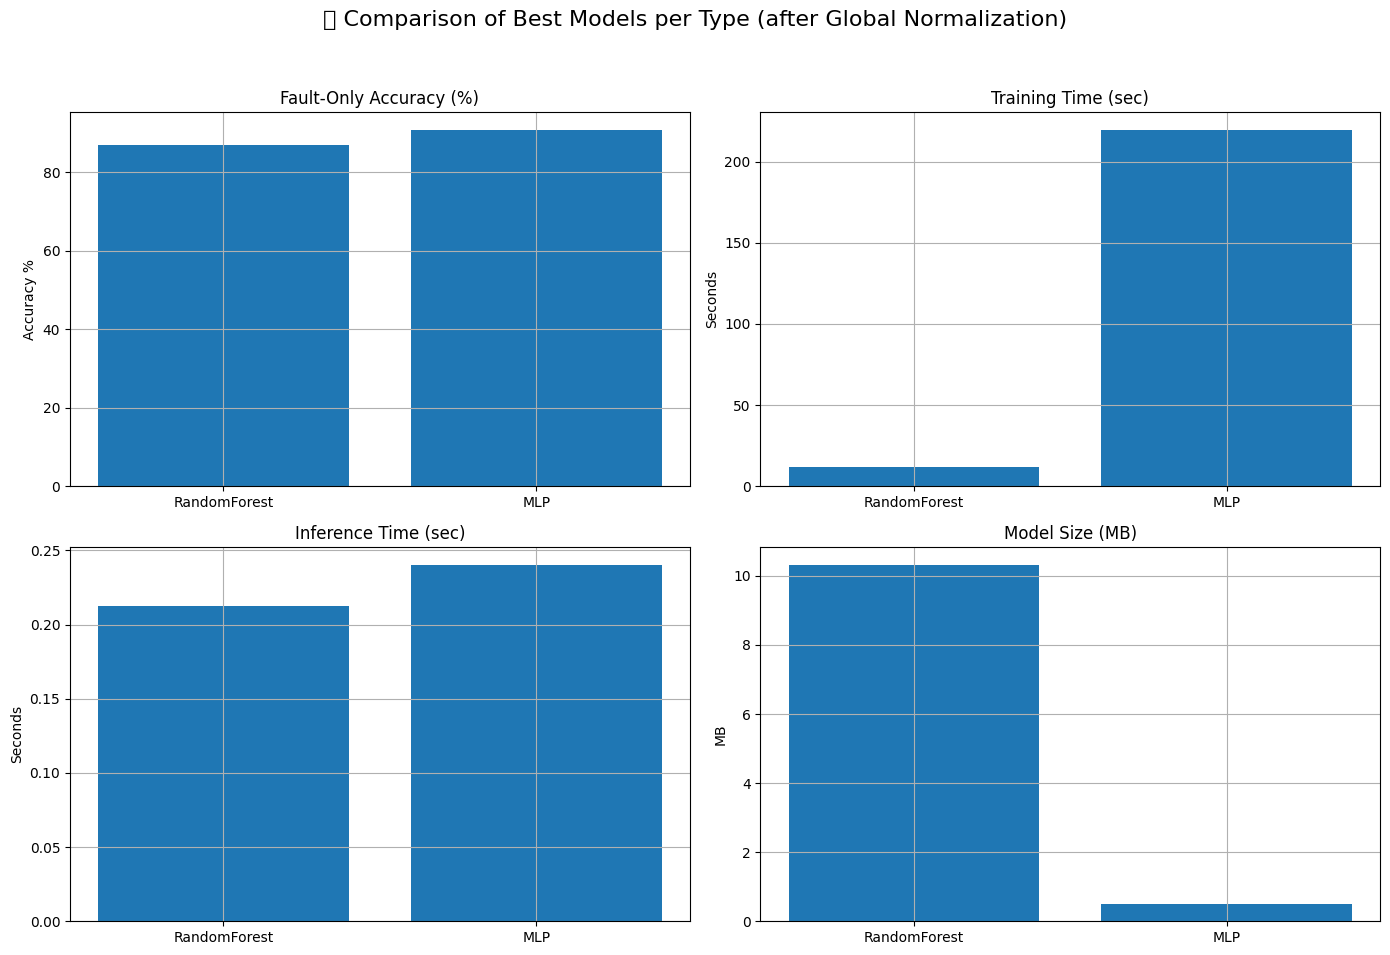

In [ ]:
import matplotlib.pyplot as plt

# --- 1. Find the Best Model per Type ---
best_per_model_type = []

for model_type in all_results_df['Model_Type'].unique():
    model_results = all_results_df[all_results_df['Model_Type'] == model_type]
    best_model = model_results.loc[model_results['cost'].idxmin()]
    best_per_model_type.append({
        'Model_Type': model_type,
        'Fault_Accuracy': best_model['fault_accuracy'],
        'Training_Time': best_model['train_time_sec'],
        'Inference_Time': best_model['inference_time_sec'],
        'Model_Size_MB': best_model['model_size_MB'],
        'Final_Cost': best_model['cost']
    })

best_per_model_df = pd.DataFrame(best_per_model_type)

# --- 2. Plotting ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Fault Accuracy
axes[0, 0].bar(best_per_model_df['Model_Type'], best_per_model_df['Fault_Accuracy'] * 100)
axes[0, 0].set_title('Fault-Only Accuracy (%)')
axes[0, 0].set_ylabel('Accuracy %')
axes[0, 0].grid(True)

# Training Time
axes[0, 1].bar(best_per_model_df['Model_Type'], best_per_model_df['Training_Time'])
axes[0, 1].set_title('Training Time (sec)')
axes[0, 1].set_ylabel('Seconds')
axes[0, 1].grid(True)

# Inference Time
axes[1, 0].bar(best_per_model_df['Model_Type'], best_per_model_df['Inference_Time'])
axes[1, 0].set_title('Inference Time (sec)')
axes[1, 0].set_ylabel('Seconds')
axes[1, 0].grid(True)

# Model Size (MB) instead of Final Cost
axes[1, 1].bar(best_per_model_df['Model_Type'], best_per_model_df['Model_Size_MB'])
axes[1, 1].set_title('Model Size (MB)')
axes[1, 1].set_ylabel('MB')
axes[1, 1].grid(True)

plt.suptitle('📊 Comparison of Best Models per Type (after Global Normalization)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
# --- 📦 Prepare ALL Models Results for Together.ai LLM Analysis ---

import requests
import pandas as pd

# ✅ Your Together.ai API key
api_key = "229905eef960292d9d57f6802e7d6514145ce8b118d53b41071db735bae972c8"  # << your key

# 1. Format the FULL results table into a text block
summary_text = ""
for idx, row in all_results_df.iterrows():
    summary_text += (
        f"\nModel Type: {row['Model_Type']}\n"
    )
    if row['Model_Type'] == 'RandomForest':
        summary_text += f" - n_estimators: {row['n_estimators']}\n"
        summary_text += f" - max_depth: {row['max_depth']}\n"
    elif row['Model_Type'] == 'MLP':
        summary_text += f" - hidden_layers: {row['hidden_layers']}\n"
        summary_text += f" - learning_rate_init: {row['learning_rate_init']}\n"

    summary_text += (
        f" - Fault-Only Accuracy: {row['fault_accuracy']*100:.2f}%\n"
        f" - Training Time: {row['train_time_sec']:.4f} sec\n"
        f" - Inference Time: {row['inference_time_sec']:.6f} sec\n"
        f" - Model Size: {row['model_size_MB']:.4f} MB\n"
        f" - Final Cost (internal): {row['cost']:.6f}\n"
    )

# 2. Create the full prompt
final_prompt = f"""
You are an expert machine learning engineer.

I have performed model selection for fault detection in a wind turbine system.

Here are ALL my trained models:

{summary_text}

Please:
- Recommend which model I should choose and WHY (consider accuracy, size, training/inference time).
- Discuss the trade-offs between the models.

Be short but professional.
"""

# 3. Call Together.ai API
url = "https://api.together.xyz/v1/chat/completions"

headers = {
    "Authorization": f"Bearer {api_key}",
    "Content-Type": "application/json"
}

body = {
    "model": "mistralai/Mistral-7B-Instruct-v0.2",  # ✅ Good strong model
    "messages": [
        {"role": "system", "content": "You are a helpful and professional machine learning assistant."},
        {"role": "user", "content": final_prompt}
    ],
    "temperature": 0.2,
    "max_tokens": 800
}

response = requests.post(url, headers=headers, json=body)

# 4. Extract and Print Recommendation
if response.status_code == 200:
    model_advice = response.json()['choices'][0]['message']['content']
    print("\n📋 Model Selection Advice from Together.ai LLM:\n")
    print(model_advice)
else:
    print(f"❌ Error: {response.status_code}")
    print(response.text)



📋 Model Selection Advice from Together.ai LLM:

 Based on the provided data, the Random Forest model with `n_estimators=100.0` and `max_depth=7.0` appears to be the best choice. It has the highest Fault-Only Accuracy (86.09%) among the Random Forest models, and its accuracy is also competitive with the MLP models. However, it's important to note that the MLP models have slightly higher accuracies, but they also have smaller sizes and shorter training/inference times.

The Random Forest model with `n_estimators=100.0` and `max_depth=7.0` has a larger size (49.5836 MB) and longer training time (77.5524 sec) compared to the MLP models. But it has a shorter inference time (2.349772 sec).

Trade-offs between models include:
- Size: The MLP models have smaller sizes, making them more efficient in terms of storage and deployment.
- Training Time: The Random Forest models have shorter training times, making them faster to train, but the MLP models require more time.
- Inference Time: The Rand